# Flower Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

## Input Data

Define paths and other parameters

In [2]:
TRAIN_PATH='../data/Flower_Data/train'
TEST_PATH='../data/Flower_Data/val'
INDIV_TEST_PATH='../data/Flower_Data/test/resized'
OUTPUT_PATH='../model'
IGNORE='.gitkeep'
IMG_HEIGHT=256
IMG_WIDTH=256
BATCH_SIZE=32
SEED=123
EPOCHS=50 # changed from 100
EARLY_STOP_ROUNDS=5
LEARNING_RATE=0.0005 # changed from 0.00005
VAL_SPLIT=0.2

### Determine Data Balance

In [3]:
cnt_dict={}
for i in os.listdir(TRAIN_PATH):
    if i != IGNORE:
        path=os.path.join(TRAIN_PATH,i)
        cnt_dict[i]=len(os.listdir(path))

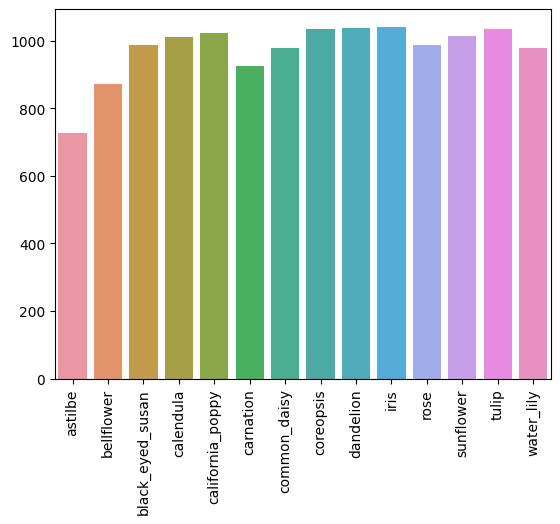

In [4]:
sns.barplot(x=list(cnt_dict.keys()),y=list(cnt_dict.values()))
plt.xticks(rotation=90)
plt.show()
# no large imbalance present

### Set up Dataset

In [5]:
train_ds = image_dataset_from_directory(TRAIN_PATH,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE,seed=SEED,
                                        validation_split=VAL_SPLIT,subset='training')
val_ds = image_dataset_from_directory(TRAIN_PATH,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE,seed=SEED,
                                      validation_split=VAL_SPLIT,subset='validation')

Found 13642 files belonging to 14 classes.
Using 10914 files for training.
Found 13642 files belonging to 14 classes.
Using 2728 files for validation.


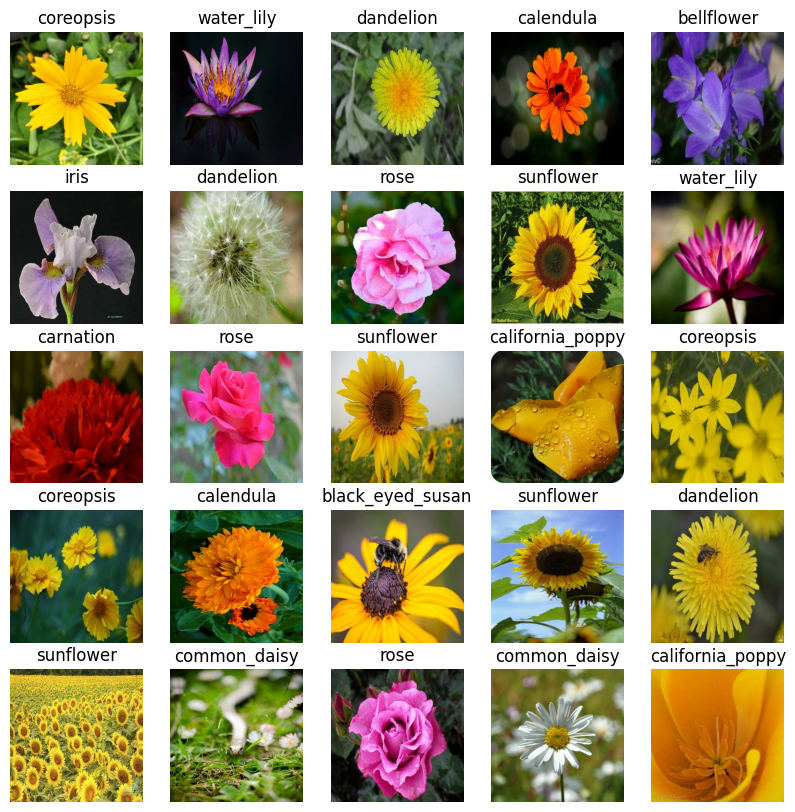

In [6]:
plt.figure(figsize=(10,10))
class_names=train_ds.class_names
num_classes=len(class_names)

for imgs,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [7]:
# wite class names into a txt file
class_path='../data/Flower_Data/class_names.txt'
with open(class_path,'w') as class_names_file:
    for i in class_names:
        class_names_file.write(i)
        class_names_file.write('\n')
    class_names_file.close()

In [8]:
# prefetch the data to speed up the training
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build CNN Model 

In [8]:
# attempt v1

# model=Sequential([
#     layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
#     layers.Rescaling(1./255),
#     layers.Conv2D(16,3,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.1),
#     layers.Conv2D(32,3,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.1),
#     layers.Conv2D(64,3,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.1),
#     layers.Conv2D(128,3,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.1),
#     layers.Conv2D(256,3,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128,activation='relu'),
#     layers.Dense(256,activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes)])

In [11]:
# attempt v2

model=Sequential([
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)])

In [12]:
optim=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optim,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,793,262 (10.66 MB)

 Trainable params: 2,793,262 (10.66 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop=EarlyStopping(monitor='loss',patience=EARLY_STOP_ROUNDS)

In [15]:
history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[early_stop])

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 211s 605ms/step - accuracy: 0.0969 - loss: 2.6020 - val_accuracy: 0.1906 - val_loss: 2.4279
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 218s 637ms/step - accuracy: 0.1826 - loss: 2.2711 - val_accuracy: 0.2408 - val_loss: 2.3073
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 222s 649ms/step - accuracy: 0.2343 - loss: 2.1371 - val_accuracy: 0.2892 - val_loss: 2.1406
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 224s 655ms/step - accuracy: 0.3123 - loss: 1.9253 - val_accuracy: 0.3497 - val_loss: 1.9998
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 225s 659ms/step - accuracy: 0.3528 - loss: 1.8111 - val_accuracy: 0.3904 - val_loss: 1.9381
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 225s 658ms/step - accuracy: 0.3794 - loss: 1.7212 - val_accuracy: 0.4230 - val_loss: 1.8628
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 229s 669ms/step - accuracy: 0.4001 - loss: 1.6611 - val_accuracy: 0.4626 - val_loss: 1.8114
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 232s 678ms/step - accuracy: 

Epoch 50/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 255s 742ms/step - accuracy: 0.8596 - loss: 0.4039 - val_accuracy: 0.6356 - val_loss: 1.2344
Epoch 51/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 253s 741ms/step - accuracy: 0.8652 - loss: 0.3882 - val_accuracy: 0.6452 - val_loss: 1.2207
Epoch 52/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 256s 750ms/step - accuracy: 0.8701 - loss: 0.3777 - val_accuracy: 0.6485 - val_loss: 1.2176
Epoch 53/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 255s 745ms/step - accuracy: 0.8754 - loss: 0.3673 - val_accuracy: 0.6433 - val_loss: 1.2124
Epoch 54/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 254s 743ms/step - accuracy: 0.8892 - loss: 0.3433 - val_accuracy: 0.6690 - val_loss: 1.1018
Epoch 55/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 256s 749ms/step - accuracy: 0.8841 - loss: 0.3382 - val_accuracy: 0.6576 - val_loss: 1.1713
Epoch 56/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 256s 748ms/step - accuracy: 0.8851 - loss: 0.3332 - val_accuracy: 0.6763 - val_loss: 1.1043
Epoch 57/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 254s 743ms/step - ac

Epoch 99/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 231s 674ms/step - accuracy: 0.9661 - loss: 0.1029 - val_accuracy: 0.6763 - val_loss: 1.4227
Epoch 100/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 216s 632ms/step - accuracy: 0.9677 - loss: 0.0933 - val_accuracy: 0.7111 - val_loss: 1.2474


In [16]:
add_on='_v2'
model.save(OUTPUT_PATH+'/flower_classification_model'+add_on+'.keras')

## Model Evaluation

### Plot Loss and Accuracy from History

In [9]:
def plot_loss_acc(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    actual_epochs=len(acc)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(range(actual_epochs),acc,label='Train')
    plt.plot(range(actual_epochs),val_acc,label='Validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(range(actual_epochs),loss,label='Train')
    plt.plot(range(actual_epochs),val_loss,label='Validation')
    plt.legend(loc='lower right')
    plt.title('Loss')

    plt.show()

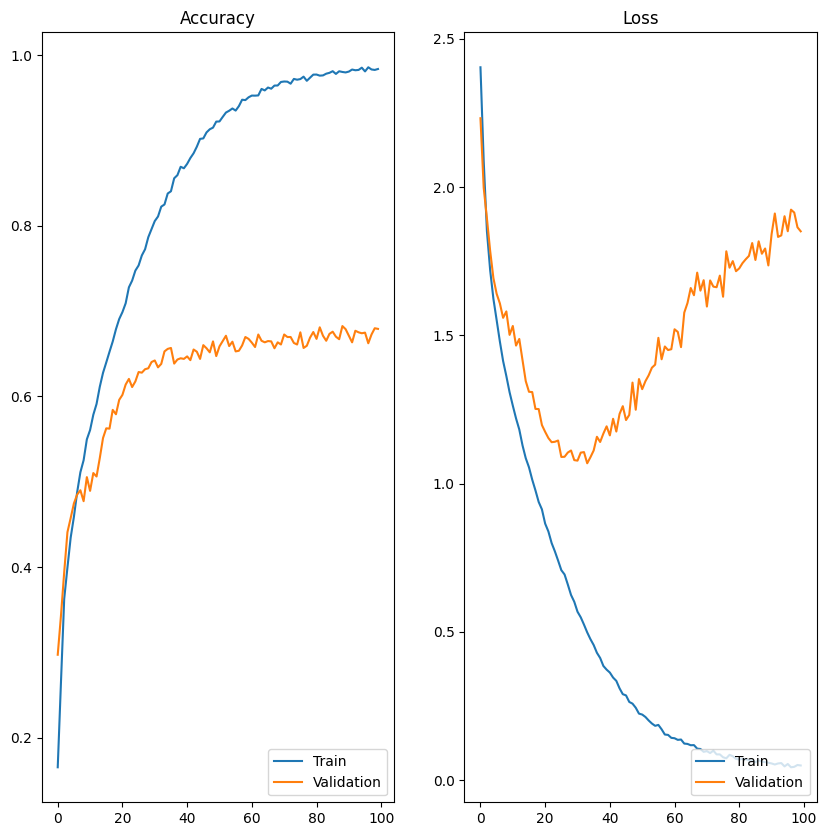

In [17]:
# v1 accuracy + loss
plot_loss_acc(history)
# the model is definetely overfitting

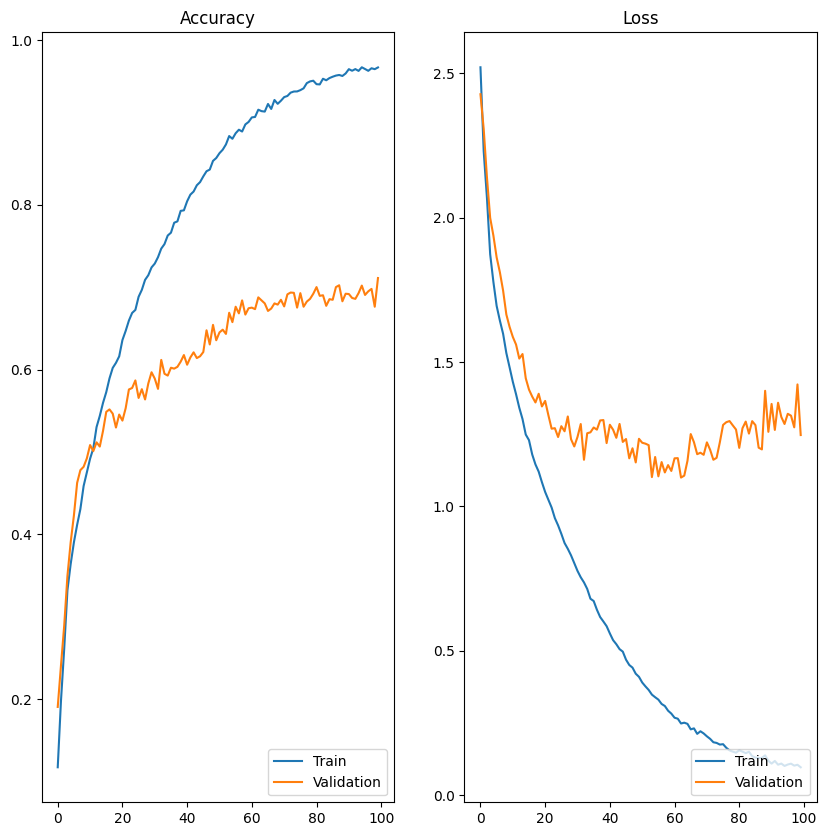

In [18]:
# v2 accuracy + loss
plot_loss_acc(history)
# probably overfitting a little still, but better than v1

### Evaluate on Test Dataset

In [33]:
save_name='flower_classification_model'
model=tf.keras.models.load_model(OUTPUT_PATH+'/'+save_name+'.keras')

In [9]:
test_ds=image_dataset_from_directory(TEST_PATH,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE)

Found 98 files belonging to 14 classes.


In [14]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7604 - loss: 1.5605


[1.6763584613800049, 0.7551020383834839]

In [10]:
# split a dataset into two np arrays of images and labels
# this is to allow predictions on the entire dataset without using .evaluate() method, which provides limited information
def split_data(ds):
    labels=[]
    img_test=[]
    for img_batch,label_batch in ds:
        labels.extend(label_batch.numpy())
        img_test.extend(img_batch.numpy())
    return np.array(img_test),np.array(labels)

In [11]:
# predict and use classifcation report and confusion matrix to compare models
def print_classification_eval(model,X_test,y_test):
    pred=np.argmax(model.predict(X_test),axis=-1)
    print(classification_report(y_test,pred))
    print('\n\n')
    mtx=confusion_matrix(y_test,pred)
    print(mtx)
    print('\n\n')
    plt.figure(figsize=(15,7))
    sns.heatmap(confusion_matrix(y_test,pred),annot=True)

In [12]:
X_test,y_test=split_data(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       0.75      0.86      0.80         7
           2       0.75      0.86      0.80         7
           3       0.80      0.57      0.67         7
           4       0.70      1.00      0.82         7
           5       0.83      0.71      0.77         7
           6       1.00      0.86      0.92         7
           7       0.57      0.57      0.57         7
           8       0.88      1.00      0.93         7
           9       1.00      1.00      1.00         7
          10       0.50      0.43      0.46         7
          11       1.00      0.86      0.92         7
          12       0.80      0.57      0.67         7
          13       1.00      0.86      0.92         7

    accuracy                           0.80        98
   macro avg       0.81      0.80      0.79        98
weighted avg       0.81      0.80      0.

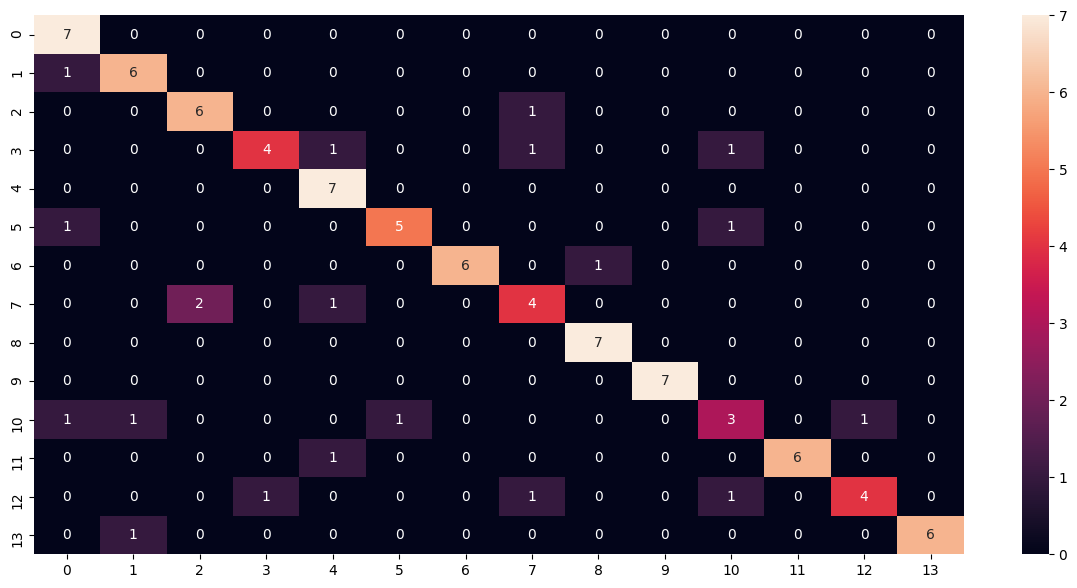

In [16]:
print_classification_eval(model,X_test,y_test)

### Predict Individual Test Images

Test images are personal photos taken and resized using ``img_resize_util``, does not appear inside of kaggle dataset.

One thing to note about my own images is that they may differ from the type of flowers that the model trains on, since for every type of flower there are still a wide variety of species with varying appearances. 

In [13]:
# predict on an individual image
def pred_individual(model,img,label,class_names):
    pred_img=np.reshape(img,(1,256,256,3))
    pred=np.argmax(model.predict(pred_img))
    pred=class_names[pred]
    plt.imshow(img)
    plt.title(f'Actual:{label}, Prediction:{pred}')

In [14]:
# read and get all photos on path, extracting both image and label into correct format
def read_photos(path):
    photos=[]
    p_labels=[]
    for img_name in os.listdir(path):
        if img_name != IGNORE:
            img_bgr=cv2.imread(INDIV_TEST_PATH+'/'+img_name)
            img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            label=img_name.split('.')[0]
            label=''.join([i for i in label if not i.isdigit()])
            p_labels.append(label)
            photos.append(img_rgb)
    return np.array(photos),np.array(p_labels)

In [15]:
photos,p_labels=read_photos(INDIV_TEST_PATH)
print(len(photos))
print(p_labels)

15
['california_poppy' 'california_poppy' 'california_poppy' 'iris' 'iris'
 'iris' 'iris' 'rose' 'rose' 'rose' 'rose' 'rose' 'rose' 'water_lily'
 'water_lily']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


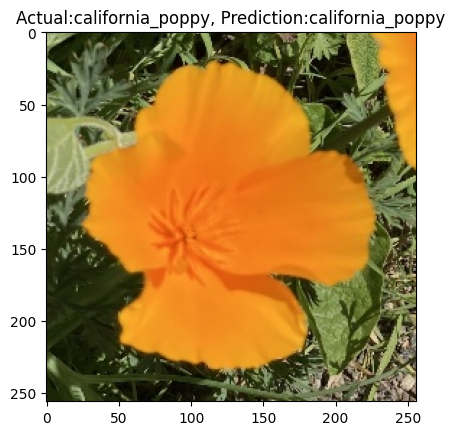

In [34]:
len_photos=len(photos)
i=np.random.choice(len_photos)
pred_individual(model,photos[i],p_labels[i],class_names)

### Overall Evaluation on Own Images

In [16]:
# convert labels into indexes for evaluation
p_indexes=[]
for i in p_labels:
    p_indexes.append(class_names.index(i))
p_indexes=np.array(p_indexes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         3
           9       1.00      0.50      0.67         4
          10       1.00      0.50      0.67         6
          13       0.67      1.00      0.80         2

    accuracy                           0.67        15
   macro avg       0.61      0.50      0.52        15
weighted avg       0.96      0.67      0.75        15




[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 1 0 2 0 1]
 [3 0 0 0 3 0]
 [0 0 0 0 0 2]]





C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


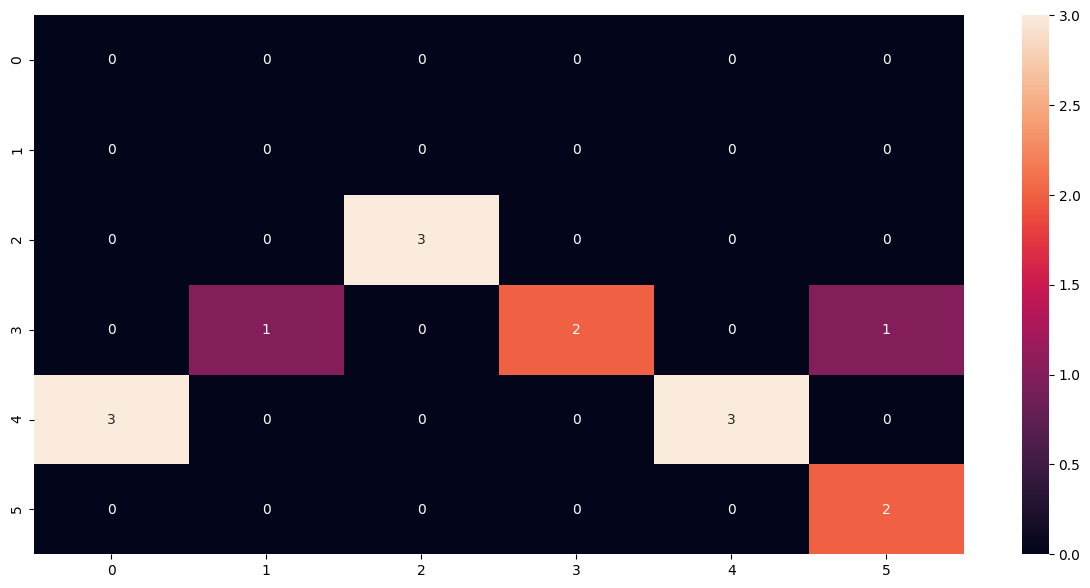

In [80]:
# while individual test images only has 4 kinds of flowers, the matrix is more than 4x4
# this is due to incorrect predictions being of an entirely different category that the model did also train on
print_classification_eval(model,photos,p_indexes)

## Data Augmentation

In [17]:
RANDOM_ROTATE_FAC=0.1
RANDOM_ZOOM_FAC=0.1
RANDOM_BRIGHTNESS_FAC=0.2
RANDOM_CONTRAST_FAC=0.2
RANDOM_FLIP='horizontal_and_vertical'

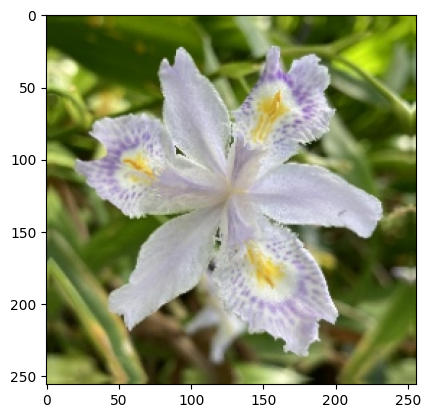

In [13]:
# test to see the differences occuring in each layer
test_img_path=INDIV_TEST_PATH+'/'+os.listdir(INDIV_TEST_PATH)[0]
test_img=cv2.imread(test_img_path)
test_img=cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
layer=layers.RandomZoom(RANDOM_ZOOM_FAC)
output=layer(test_img)
plt.imshow(output.numpy().astype('uint8'))

In [86]:
data_augmentation=Sequential([
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    layers.RandomFlip(RANDOM_FLIP),
    layers.RandomRotation(RANDOM_ROTATE_FAC),
    layers.RandomZoom(RANDOM_ZOOM_FAC),
    layers.RandomBrightness(RANDOM_BRIGHTNESS_FAC),
    layers.RandomContrast(RANDOM_BRIGHTNESS_FAC)])

### Version 1

In [11]:
# using v2 last section's paired with data augmentation
model=Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)])

In [19]:
def compile_train_tf_model(model,opt,save_name='',logits=True):
    model.compile(optimizer=optim,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=logits),metrics=['accuracy'])
    model.summary()
    early_stop=EarlyStopping(monitor='loss',patience=EARLY_STOP_ROUNDS)
    history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[early_stop])
    if len(save_name) > 0:
        model.save(OUTPUT_PATH+'/'+save_name+'.keras')
    return history

In [13]:
save_name='flower_classification_model_data_aug'
optim=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
history=compile_train_tf_model(model,optim,save_name)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 241s 692ms/step - accuracy: 0.0803 - loss: 2.6322 - val_accuracy: 0.1859 - val_loss: 2.4326
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 240s 701ms/step - accuracy: 0.1725 - loss: 2.3190 - val_accuracy: 0.2372 - val_loss: 2.3042
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 296s 867ms/step - accuracy: 0.2335 - loss: 2.1223 - val_accuracy: 0.3215 - val_loss: 2.1277
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 305s 893ms/step - accuracy: 0.3025 - loss: 1.9259 - val_accuracy: 0.3743 - val_loss: 2.0187
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 308s 901ms/step - accuracy: 0.3295 - loss: 1.8452 - val_accuracy: 0.3831 - val_loss: 1.9490
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 310s 908ms/step - accuracy: 0.3447 - loss: 1.7829 - val_accuracy: 0.3966 - val_loss: 1.9228
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 313s 916ms/step - accuracy: 0.3670 - loss: 1.7205 - val_accuracy: 0.4340 - val_loss: 1.8693
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 312s 913ms/step - accuracy: 

Epoch 50/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 262s 766ms/step - accuracy: 0.6618 - loss: 0.9674 - val_accuracy: 0.6562 - val_loss: 1.0508
Epoch 51/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 271s 792ms/step - accuracy: 0.6746 - loss: 0.9545 - val_accuracy: 0.6529 - val_loss: 1.0432
Epoch 52/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 260s 761ms/step - accuracy: 0.6708 - loss: 0.9491 - val_accuracy: 0.6243 - val_loss: 1.1236
Epoch 53/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 259s 758ms/step - accuracy: 0.6806 - loss: 0.9410 - val_accuracy: 0.6584 - val_loss: 1.0102
Epoch 54/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 261s 763ms/step - accuracy: 0.6790 - loss: 0.9265 - val_accuracy: 0.6525 - val_loss: 1.0295
Epoch 55/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 265s 774ms/step - accuracy: 0.6903 - loss: 0.9088 - val_accuracy: 0.6543 - val_loss: 1.0055
Epoch 56/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 270s 791ms/step - accuracy: 0.6924 - loss: 0.8997 - val_accuracy: 0.6481 - val_loss: 1.0683
Epoch 57/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 259s 757ms/step - ac

Epoch 99/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 283s 827ms/step - accuracy: 0.7867 - loss: 0.6246 - val_accuracy: 0.7133 - val_loss: 0.8872
Epoch 100/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 315s 921ms/step - accuracy: 0.7887 - loss: 0.6196 - val_accuracy: 0.7247 - val_loss: 0.8660


### Version 2 of Model with Data Augmentation

The previous model's overall accuracy was still not good, so considered a new structure to see if there is improvement. Also changed the learning rate and epochs parameters.
- learning_rate: 0.00005 -- 0.0005
- epochs: 100 -- 50

In [17]:
model=Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation='softmax')])

In [18]:
# originally was a quick last-minute test, so didn't use compile_train_tf_model method
# kept because the accuracy turned out much better
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# EPOCHS=50
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS)

Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 334s 940ms/step - accuracy: 0.1122 - loss: 2.4725 - val_accuracy: 0.2053 - val_loss: 2.1381
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 326s 953ms/step - accuracy: 0.2664 - loss: 1.9299 - val_accuracy: 0.4018 - val_loss: 1.7822
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 319s 930ms/step - accuracy: 0.3817 - loss: 1.6753 - val_accuracy: 0.4476 - val_loss: 1.6589
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 316s 925ms/step - accuracy: 0.4496 - loss: 1.5476 - val_accuracy: 0.4776 - val_loss: 1.4922
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 316s 923ms/step - accuracy: 0.4877 - loss: 1.4446 - val_accuracy: 0.5132 - val_loss: 1.4118
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 316s 925ms/step - accuracy: 0.5185 - loss: 1.3607 - val_accuracy: 0.5495 - val_loss: 1.3028
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 316s 924ms/step - accuracy: 0.5330 - loss: 1.2967 - val_accuracy: 0.5803 - val_loss: 1.2293
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 313s 914ms/step - accuracy: 0.5587 -

In [19]:
save_name='flower_classification_model_data_aug_v2'
model.save(OUTPUT_PATH+'/'+save_name+'.keras')

### Evaluate & Compare
Methods and variables all defined above in previous model evaluation

In [19]:
# contains all evaluation metrics used previously and combines into one to reduce redundancy of code
# history is optional in case the model was loaded in, since history is not saved
def eval_model(model,load_name='',history=None):
    if len(load_name)>0:
        model=tf.keras.models.load_model(OUTPUT_PATH+'/'+load_name+'.keras')
    test_ds=image_dataset_from_directory(TEST_PATH,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE)
    X_test,y_test=split_data(test_ds)
    
    model.evaluate(test_ds)
    print_classification_eval(model,X_test,y_test)
    if history is not None:
        plot_loss_acc(history)

Found 98 files belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7085 - loss: 0.7102
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/stepWARNING:tensorflow:6 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A26A7AD300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
              precision    recall  f1-score   support

           0       0.50     

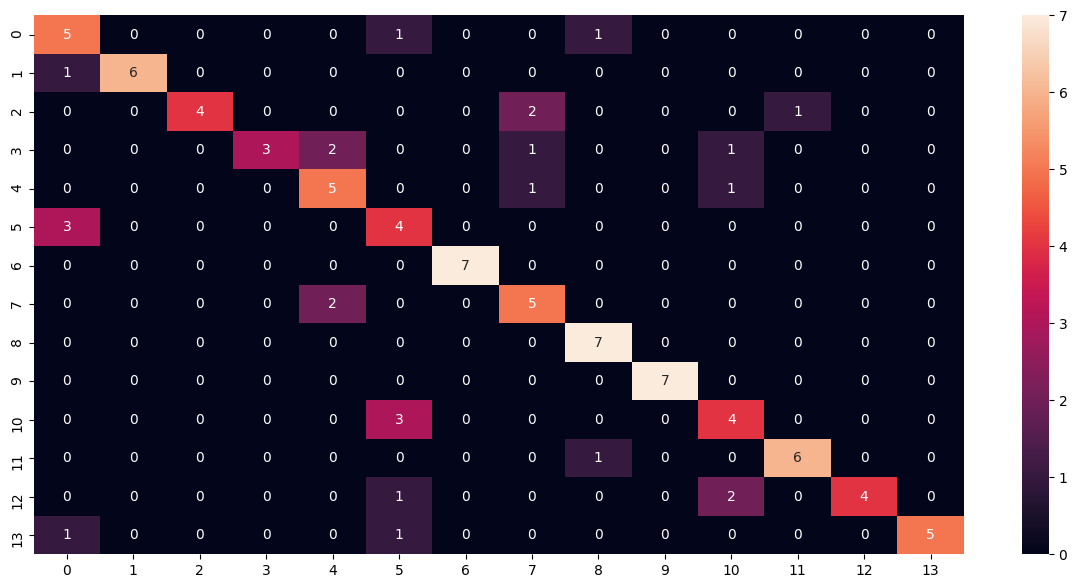

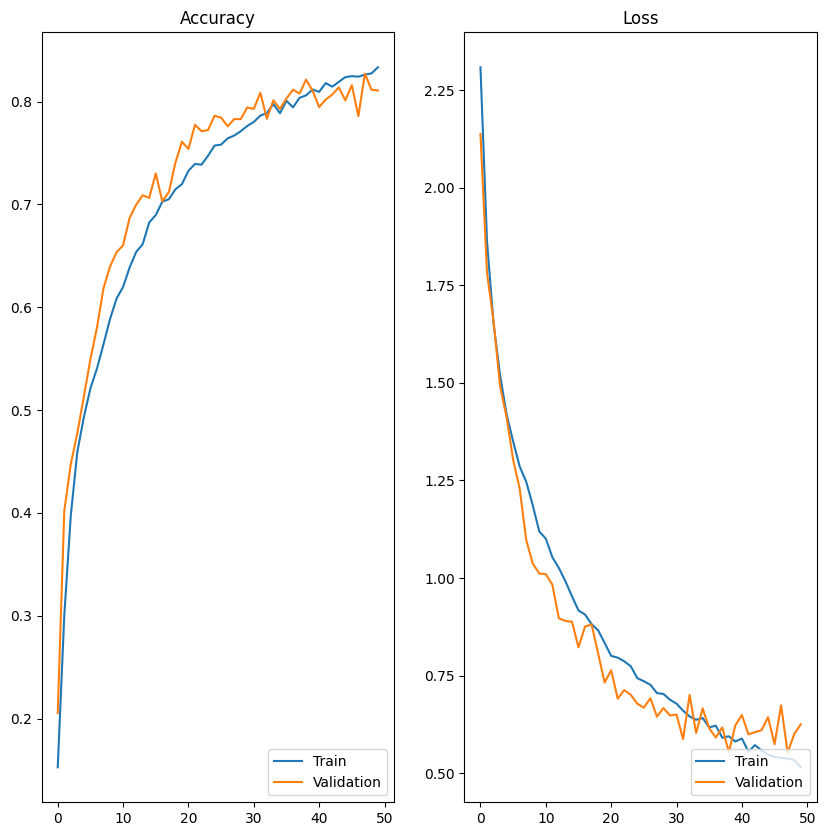

In [109]:
# version 1: flower_classification_model_data_aug
save_name='flower_classification_model_data_aug'
model=tf.keras.models.load_model(OUTPUT_PATH+'/'+save_name+'.keras')
eval_model(model,history=history)

Found 98 files belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8358 - loss: 0.5095
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.86      0.86      0.86         7
           2       1.00      1.00      1.00         7
           3       1.00      0.43      0.60         7
           4       0.67      0.86      0.75         7
           5       0.50      0.57      0.53         7
           6       0.78      1.00      0.88         7
           7       0.86      0.86      0.86         7
           8       0.88      1.00      0.93         7
           9       0.78      1.00      0.88         7
          10       0.83      0.71      0.77         7
          11       1.00      1.00      1.00         7
          12       1.00      0.71      0.83         7
          13       0.83      0.71      0.77         7

    accuracy                        

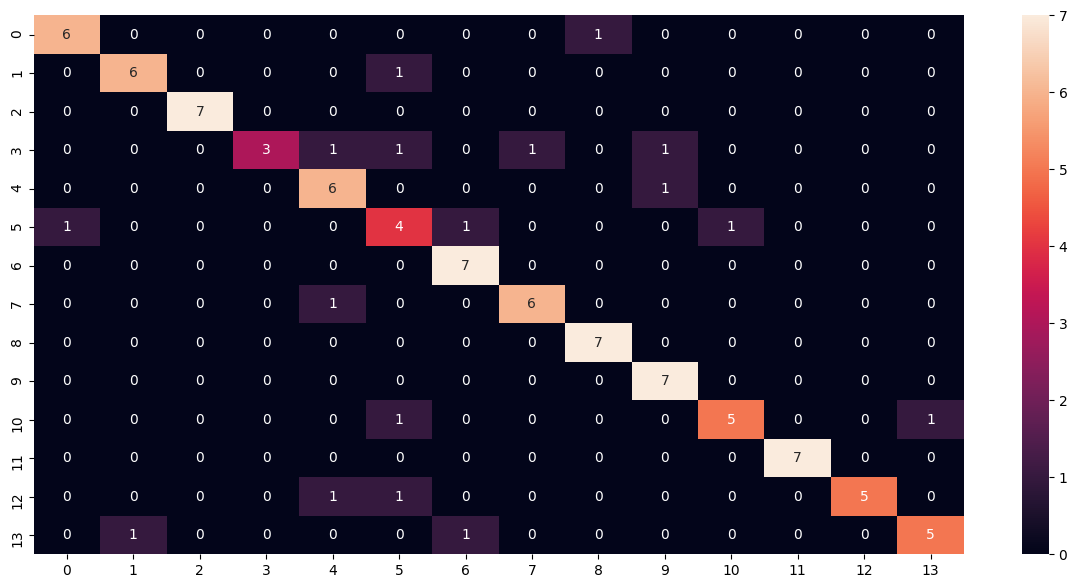

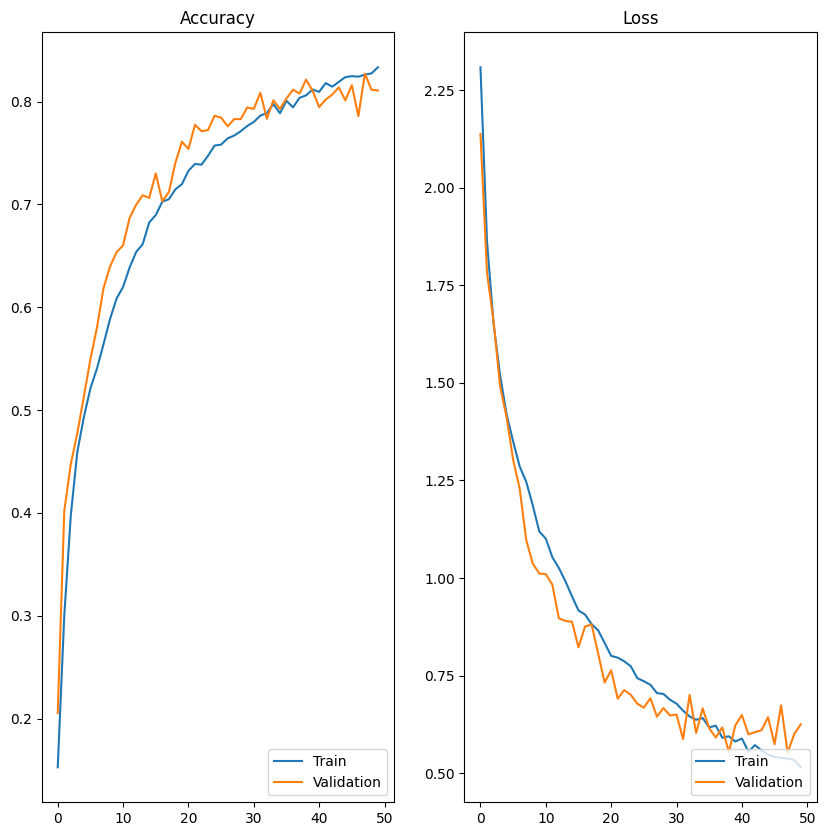

In [88]:
# version 2:flower_classification_model_data_aug_v2
eval_model(model,history=history)
# can observe clear improvement, but there may be a bit of overfitting towards the end

#### My Own Images - Individual

In [35]:
save_name='flower_classification_model_data_aug_v2'
model=tf.keras.models.load_model(OUTPUT_PATH+'/'+save_name+'.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


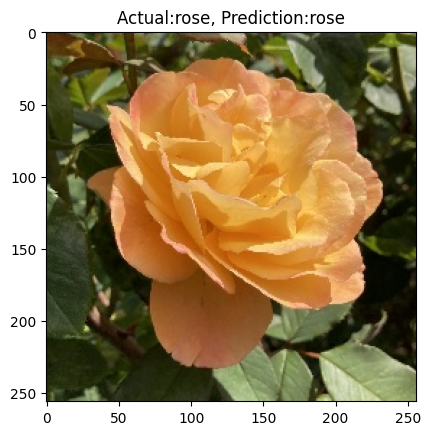

In [36]:
len_photos=len(photos)
i=np.random.choice(len_photos)
pred_individual(model,photos[i],p_labels[i],class_names)

#### My Own Images - Overall

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         0
           9       1.00      0.50      0.67         4
          10       0.75      0.50      0.60         6
          13       1.00      0.50      0.67         2

    accuracy                           0.60        15
   macro avg       0.62      0.42      0.49        15
weighted avg       0.90      0.60      0.71        15




[[0 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 0 0 0 0]
 [2 0 0 2 0 0]
 [0 0 3 0 3 0]
 [0 0 0 0 1 1]]





C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


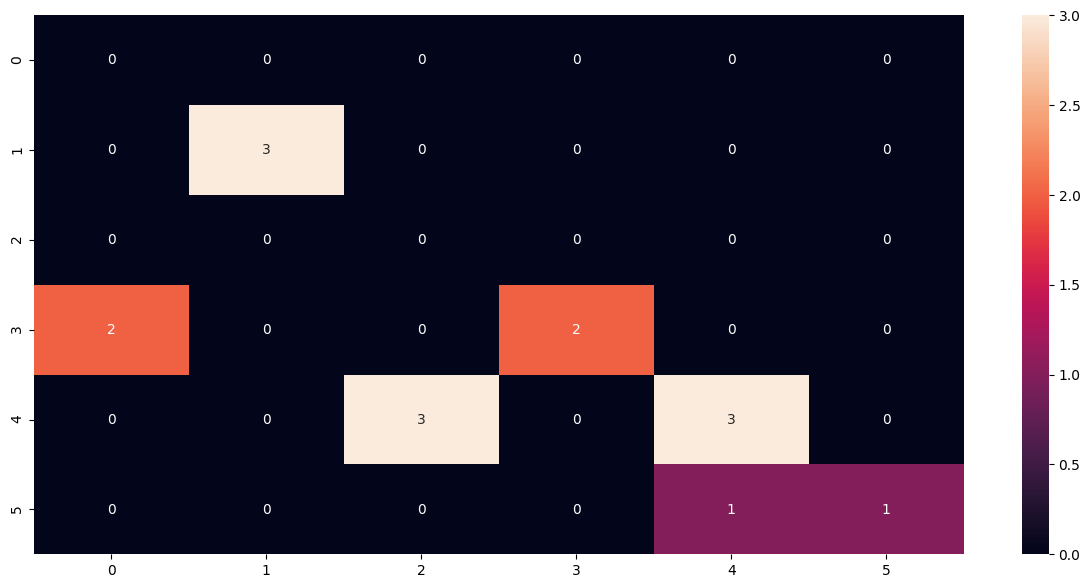

In [37]:
print_classification_eval(model,photos,p_indexes)
# Didn't change as much from previous test on my own images
# As mentioned before may be due to these images not being the same species/style as those in train dataset

## Using Pretrained Models - Transfer Learning

In [20]:
# redefined compile_train_tf_model for transfer learning models
def compile_train_pretrain_model(pretrain_model,optim=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),save_name=''):
    pretrain_model.compile(optimizer=optim,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    pretrain_model.summary()
    early_stop=EarlyStopping(monitor='loss',patience=EARLY_STOP_ROUNDS,restore_best_weights=True) # less epochs so ok to try
        
    history=pretrain_model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[early_stop])
    if len(save_name) > 0:
        pretrain_model.save(OUTPUT_PATH+'/'+save_name+'.keras')
    return history

In [21]:
# streamline building of transfer learning model
def build_tf_pretrained(pretrained_model):
    data_augmentation=Sequential([
        layers.RandomFlip(RANDOM_FLIP),
        layers.RandomRotation(RANDOM_ROTATE_FAC),
        layers.RandomZoom(RANDOM_ZOOM_FAC),
        layers.RandomBrightness(RANDOM_BRIGHTNESS_FAC),
        layers.RandomContrast(RANDOM_BRIGHTNESS_FAC)])
    
    pretrained_model.trainable=False  
    model=Sequential([layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
                      data_augmentation,
                      layers.Rescaling(1./255),
                      pretrained_model,
                      layers.Dropout(0.2),
                      layers.Flatten(),
                      layers.Dense(num_classes,activation='softmax')])

    return model

### VGG16

In [23]:
EPOCHS=10
EARLY_STOP_ROUNDS=3

In [24]:
from keras.applications.vgg16 import VGG16

In [25]:
vgg16=VGG16(weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False)
vggmodel=build_tf_pretrained(vgg16)

In [26]:
optim=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
save_name='flower_classification_model_vgg16'
history=compile_train_pretrain_model(vggmodel,save_name=save_name)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │         458,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,173,454 (57.88 MB)

 Trainable params: 458,766 (1.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3048s 9s/step - accuracy: 0.5029 - loss: 1.5725 - val_accuracy: 0.7419 - val_loss: 0.8592
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2331s 7s/step - accuracy: 0.7428 - loss: 0.8074 - val_accuracy: 0.7801 - val_loss: 0.6985
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2885s 8s/step - accuracy: 0.7779 - loss: 0.6996 - val_accuracy: 0.7984 - val_loss: 0.6559
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2735s 8s/step - accuracy: 0.7963 - loss: 0.6250 - val_accuracy: 0.7944 - val_loss: 0.6345
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2910s 9s/step - accuracy: 0.8144 - loss: 0.5760 - val_accuracy: 0.8185 - val_loss: 0.5982
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2920s 9s/step - accuracy: 0.8128 - loss: 0.5924 - val_accuracy: 0.8090 - val_loss: 0.6629
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2949s 9s/step - accuracy: 0.8315 - loss: 0.5330 - val_accuracy: 0.8215 - val_loss: 0.5790
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2971s 9s/step - accuracy: 0.8352 - loss: 0.5073 - 

Found 98 files belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.8015 - loss: 0.5604
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.75      0.86      0.80         7
           2       1.00      0.71      0.83         7
           3       0.58      1.00      0.74         7
           4       0.80      0.57      0.67         7
           5       1.00      0.57      0.73         7
           6       0.80      0.57      0.67         7
           7       0.71      0.71      0.71         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       0.64      1.00      0.78         7
          11       1.00      1.00      1.00         7
          12       0.88      1.00      0.93         7
          13       0.71      0.71      0.71         7

    accuracy                           0

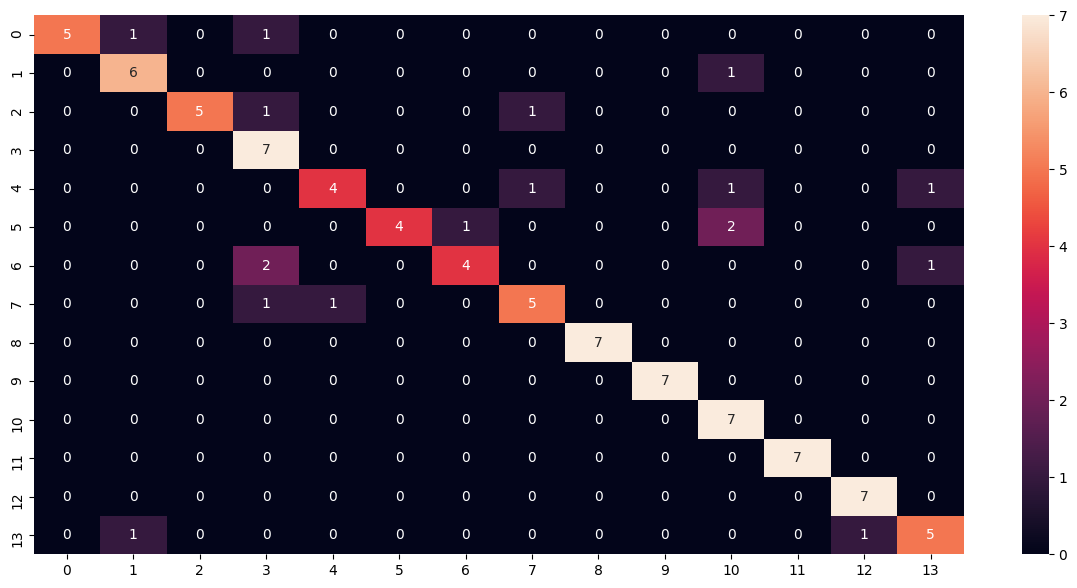

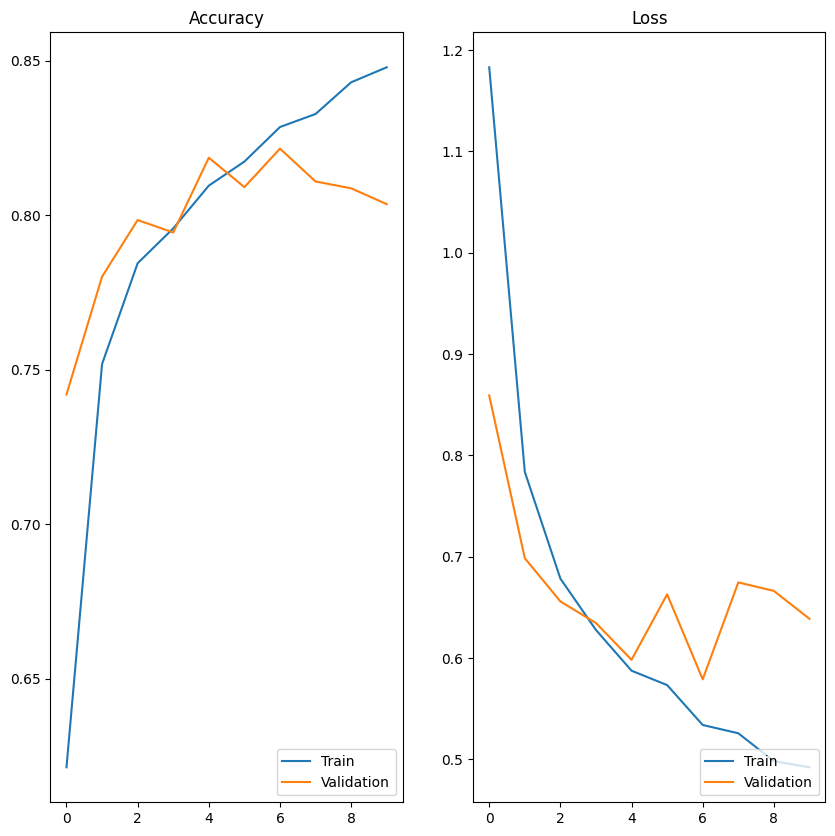

In [27]:
eval_model(vggmodel,history=history)

### Resnet50

In [27]:
EPOCHS=30

In [28]:
from keras.applications.resnet import ResNet50

In [29]:
resnet50=ResNet50(weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False)
resnet50_model=build_tf_pretrained(resnet50)

In [30]:
save_name='flower_classification_model_resnet50'
history=compile_train_pretrain_model(resnet50_model,save_name=save_name)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │       1,835,022 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,422,734 (96.98 MB)

 Trainable params: 1,835,022 (7.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1173s 3s/step - accuracy: 0.1155 - loss: 5.5583 - val_accuracy: 0.1180 - val_loss: 6.1951
Epoch 2/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1117s 3s/step - accuracy: 0.1821 - loss: 3.8496 - val_accuracy: 0.1147 - val_loss: 6.5146
Epoch 3/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1128s 3s/step - accuracy: 0.2231 - loss: 3.7879 - val_accuracy: 0.1826 - val_loss: 4.5075
Epoch 4/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1013s 3s/step - accuracy: 0.2655 - loss: 3.1566 - val_accuracy: 0.1957 - val_loss: 3.7330
Epoch 5/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 946s 3s/step - accuracy: 0.2846 - loss: 3.0142 - val_accuracy: 0.1763 - val_loss: 5.1588
Epoch 6/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 967s 3s/step - accuracy: 0.2903 - loss: 3.1647 - val_accuracy: 0.2650 - val_loss: 3.9843
Epoch 7/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 999s 3s/step - accuracy: 0.2959 - loss: 3.0479 - val_accuracy: 0.2834 - val_loss: 3.0334
Epoch 8/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1076s 3s/step - accuracy: 0.3025 - loss: 2.9029 - val

In [42]:
# tried different optimizer
history=compile_train_pretrain_model(resnet50_model,optim=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
                                     save_name=save_name)
# error occured, but the accuracy can be observed to be not much better

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │       1,835,022 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,422,734 (96.98 MB)

 Trainable params: 1,835,022 (7.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.1910 - loss: 10.8763 - val_accuracy: 0.0762 - val_loss: 25.8634
Epoch 2/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1001s 3s/step - accuracy: 0.2028 - loss: 9.5031 - val_accuracy: 0.0883 - val_loss: 20.7161
Epoch 3/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 968s 3s/step - accuracy: 0.2090 - loss: 8.9621 - val_accuracy: 0.0744 - val_loss: 21.8376
Epoch 4/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 975s 3s/step - accuracy: 0.2129 - loss: 8.7954 - val_accuracy: 0.0916 - val_loss: 15.2276
Epoch 5/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 956s 3s/step - accuracy: 0.2205 - loss: 8.6239 - val_accuracy: 0.0759 - val_loss: 25.8028
Epoch 6/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 987s 3s/step - accuracy: 0.2315 - loss: 8.5781 - val_accuracy: 0.1532 - val_loss: 12.7439
Epoch 7/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - accuracy: 0.2349 - loss: 8.2060 - val_accuracy: 0.2973 - val_loss: 6.3239
Epoch 8/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.2509 - loss: 8.1227 

AbortedError: Graph execution error:

Detected at node sequential_1_1/resnet50_1/conv5_block1_2_conv_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\14087\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\14087\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\14087\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\14087\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\14087\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\14087\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\14087\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\14087\AppData\Local\Temp\ipykernel_12044\3855805612.py", line 1, in <module>

  File "C:\Users\14087\AppData\Local\Temp\ipykernel_12044\1313978803.py", line 6, in compile_train_pretrain_model

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 343, in fit

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 429, in evaluate

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 165, in one_step_on_iterator

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in one_step_on_data

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 82, in test_step

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\14087\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 253, in call

Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node sequential_1_1/resnet50_1/conv5_block1_2_conv_1/add}}]] [Op:__inference_one_step_on_iterator_151778]

Found 98 files belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2263 - loss: 3.4563
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       1.00      0.14      0.25         7
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         7
           6       0.25      0.14      0.18         7
           7       0.12      0.14      0.13         7
           8       0.50      0.57      0.53         7
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         7
          11       0.67      0.57      0.62         7
          12       0.67      0.29      0.40         7
          13       0.11      1.00      0.19         7

    accuracy                           0.2

C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


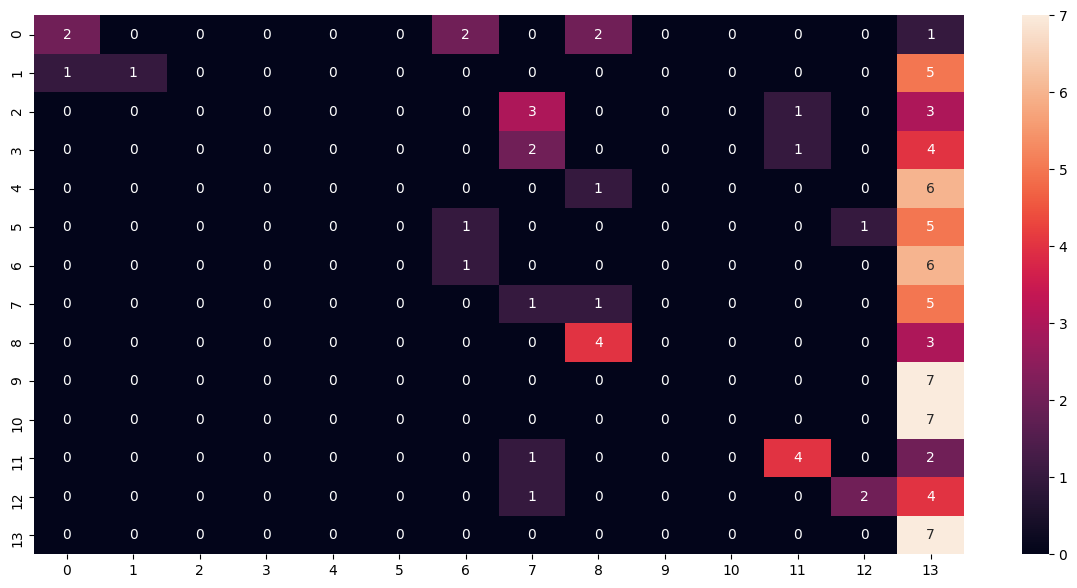

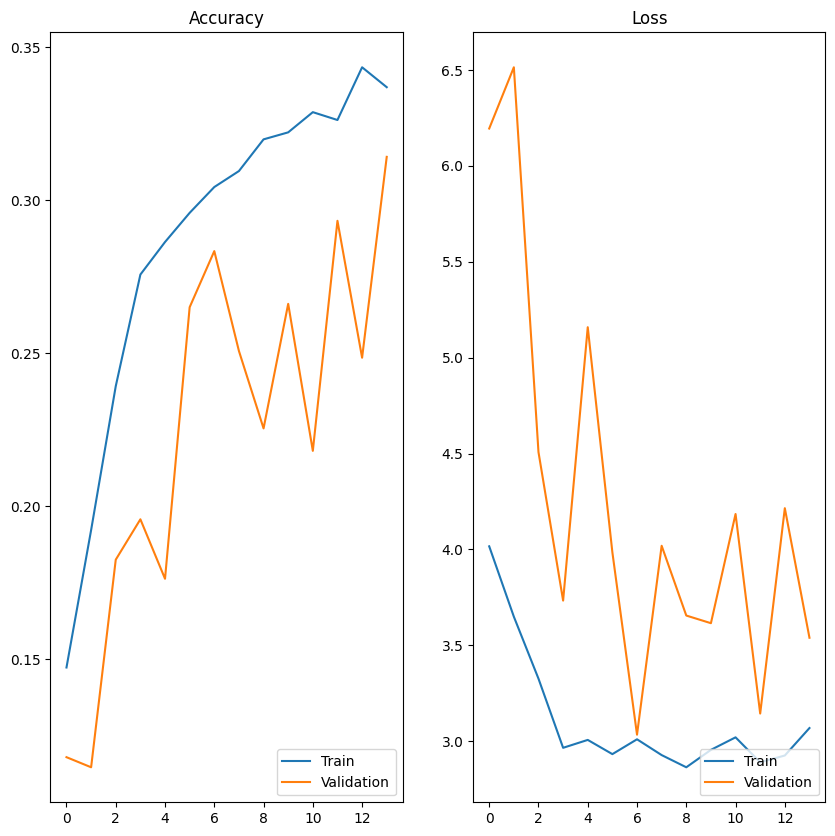

In [36]:
eval_model(resnet50_model,history=history)

### InceptionV3

In [22]:
EPOCHS=5 
# any more than 5 EPOCHS ends in could not create memory error

In [23]:
from keras.applications.inception_v3 import InceptionV3

In [24]:
inceptionv3=InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False)
inceptionv3_model=build_tf_pretrained(inceptionv3)

In [25]:
save_name='flower_classification_model_inceptionv3'
optim=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
history=compile_train_pretrain_model(inceptionv3_model,optim,save_name)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │       1,032,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,834,990 (87.11 MB)

 Trainable params: 1,032,206 (3.94 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.5894 - loss: 2.6785 - val_accuracy: 0.7434 - val_loss: 2.2834
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.7611 - loss: 1.8077 - val_accuracy: 0.7848 - val_loss: 1.6729
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.8076 - loss: 1.5140 - val_accuracy: 0.7588 - val_loss: 2.2373
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - accuracy: 0.8240 - loss: 1.4799 - val_accuracy: 0.8248 - val_loss: 1.5763
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.8401 - loss: 1.4190 - val_accuracy: 0.8314 - val_loss: 1.6607


Found 98 files belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.8604 - loss: 1.1967
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         7
           3       0.50      0.57      0.53         7
           4       0.80      0.57      0.67         7
           5       0.83      0.71      0.77         7
           6       0.70      1.00      0.82         7
           7       0.86      0.86      0.86         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       0.88      1.00      0.93         7
          11       1.00      1.00      1.00         7
          12       1.00      0.86      0.92         7
          13       1.00      0.86      0.92         7

    accuracy                         

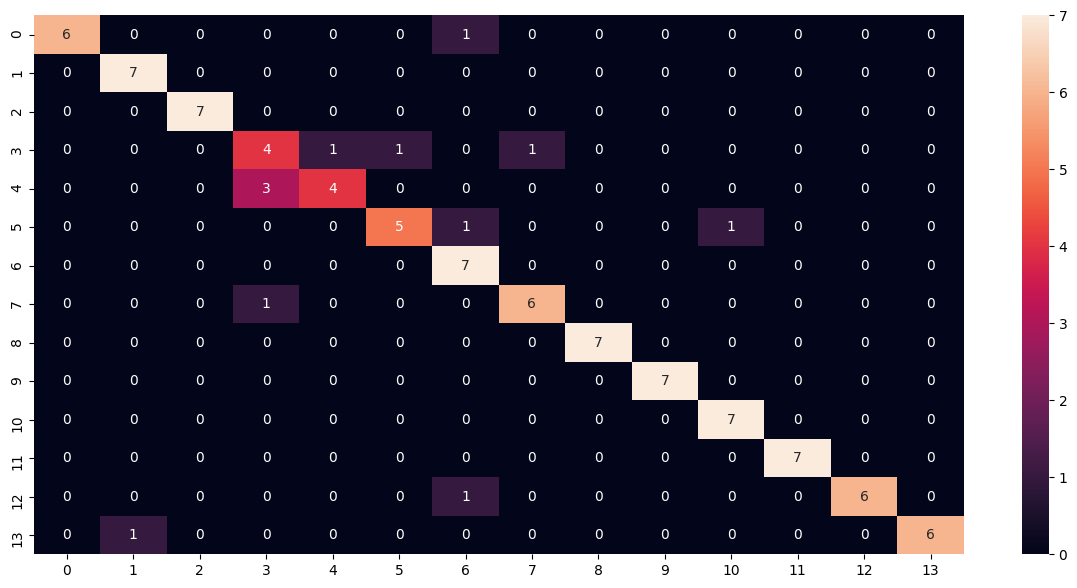

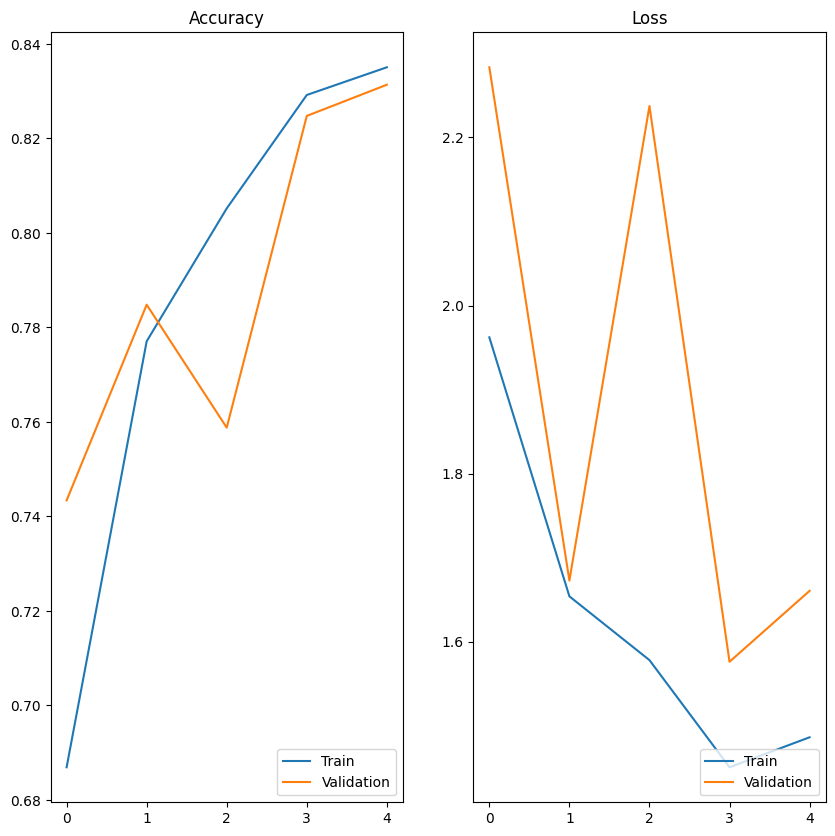

In [26]:
eval_model(inceptionv3_model,history=history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         3
           9       0.67      1.00      0.80         4
          10       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         2

    accuracy                           0.87        15
   macro avg       0.67      0.75      0.70        15
weighted avg       0.78      0.87      0.81        15




[[3 0 0 0]
 [0 4 0 0]
 [0 0 6 0]
 [0 2 0 0]]





C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\14087\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


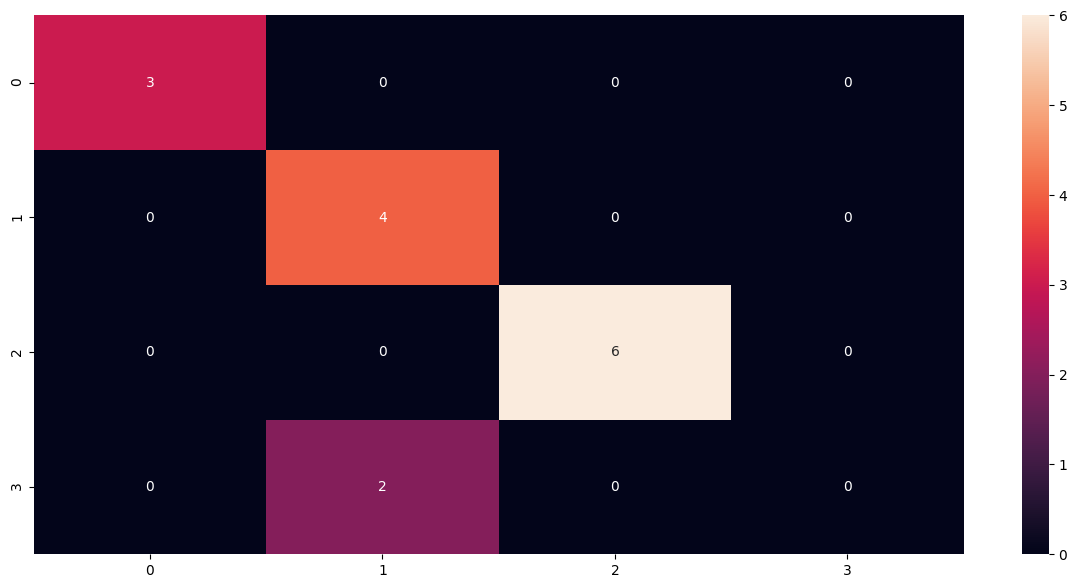

In [28]:
print_classification_eval(inceptionv3_model,photos,p_indexes)

## PyTorch

In [3]:
NUM_CLASSES=14

In [4]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch import nn
import torch.nn.functional as F

In [5]:
RANDOM_FLIP=0.5
RANDOM_ROTATE=(-30,30)
RANDOM_BRIGHTNESS_FAC=0.2
RANDOM_CONTRAST_FAC=0.2

In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), antialias=True),
    transforms.RandomHorizontalFlip(p=RANDOM_FLIP),
    transforms.RandomVerticalFlip(p=RANDOM_FLIP),
    transforms.RandomRotation(RANDOM_ROTATE),
    transforms.ColorJitter(brightness=RANDOM_BRIGHTNESS_FAC,contrast=RANDOM_CONTRAST_FAC),
    transforms.ToTensor()
])

In [6]:
# changed BATCH_SIZE from 32 starting from v3
BATCH_SIZE=128

In [8]:
torch_train = datasets.ImageFolder(TRAIN_PATH, transform=transform)
torch_test = datasets.ImageFolder(TEST_PATH, transform=transform)

train_loader = torch.utils.data.DataLoader(torch_train, batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(torch_test, batch_size=BATCH_SIZE,shuffle=True)

Text(0.5, 1.0, 'tensor(13)')

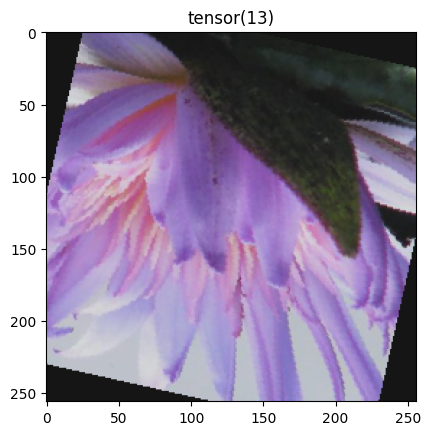

In [27]:
# change this to the trainloader or testloader 
data_iter = iter(test_loader)

images,labels = next(data_iter)
plt.imshow(np.transpose(images[1], (1, 2, 0)))
plt.title(labels[1])

### Version 1 - Preliminary PyTorch Model Training

In [355]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        
        self.pool=nn.MaxPool2d(2,2)
        self.conv1=nn.Conv2d(3,12,kernel_size=(3,3))
        self.conv2=nn.Conv2d(12,24,kernel_size=(3,3))
        self.conv3=nn.Conv2d(24,24,kernel_size=(3,3))
        self.conv4=nn.Conv2d(24,48,kernel_size=(3,3))
        self.drop=nn.Dropout(0.2)
        
        self.lin1=nn.Linear(48*14*14,256)
        self.lin2=nn.Linear(256,128)
        self.lin3=nn.Linear(128,num_classes)
        
    def forward(self,x):
        x=F.relu(self.pool(self.conv1(x)))
        # print(x.shape)
        x=F.relu(self.pool(self.conv2(x)))
        # print(x.shape)
        x=F.dropout(self.drop(x),training=self.training)
        # print(x.shape)
        x=F.relu(self.pool(self.conv3(x)))
        # print(x.shape)
        x=F.relu(self.pool(self.conv4(x)))
        # print(x.shape)
        x=F.dropout(self.drop(x),training=self.training)
        # print('b4 flat:',x.shape)
        x=x.view(-1,48*14*14)
        x=F.relu(self.lin1(x))
        x=F.relu(self.lin2(x))
        x=F.relu(self.lin3(x))
        
        return torch.log_softmax(x,dim=1)

In [345]:
def train(model,train,crit,optim,epoch):
    model.train()
    train_loss=0
    for batch_i,(img,label) in enumerate(train):
        optim.zero_grad()
        pred=model(img)
        loss=crit(pred,label)
        train_loss+=loss.item()
        loss.backward()
        optim.step()
    avg_loss=train_loss/(batch_i+1)
    print(f'Epoch: {epoch}; Training Avg Loss: {avg_loss}')

In [346]:
def validation(model,test,crit,optim):
    model.eval()
    test_loss=0
    correct=0
    batch=0
    for img,label in test:
        batch+=1
        pred=model(img)
        test_loss+=crit(pred,label).item()
        _,pred_label=torch.max(pred.data,1)
        correct+=torch.sum(label==pred_label).item()
    avg_loss=test_loss/batch
    acc=100*(correct/len(test.dataset))
    print(f'\tValidation Avg Loss: {avg_loss}, Accuracy:{acc:.2f}%')

In [356]:
model=CNN(num_classes=NUM_CLASSES)
criterion=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [348]:
EPOCHS=50

In [358]:
for epoch in range(1,EPOCHS+1):
    train(model,train_loader,criterion,optim,epoch)
    validation(model,test_loader,criterion,optim)

Epoch: 1; Training Avg Loss: 2.50308
	Validation Avg Loss: 2.23743, Accuracy:29.59%
Epoch: 2; Training Avg Loss: 2.36195
	Validation Avg Loss: 2.51080, Accuracy:17.35%
Epoch: 3; Training Avg Loss: 2.33733
	Validation Avg Loss: 2.45795, Accuracy:21.43%
Epoch: 4; Training Avg Loss: 2.29866
	Validation Avg Loss: 2.27162, Accuracy:25.51%
Epoch: 5; Training Avg Loss: 2.27956
	Validation Avg Loss: 2.37473, Accuracy:27.55%
Epoch: 6; Training Avg Loss: 2.24005
	Validation Avg Loss: 2.34449, Accuracy:34.69%
Epoch: 7; Training Avg Loss: 2.19027
	Validation Avg Loss: 2.04236, Accuracy:34.69%
Epoch: 8; Training Avg Loss: 2.16037
	Validation Avg Loss: 1.87266, Accuracy:34.69%
Epoch: 9; Training Avg Loss: 2.14203
	Validation Avg Loss: 2.43866, Accuracy:31.63%
Epoch: 10; Training Avg Loss: 2.12465
	Validation Avg Loss: 2.12343, Accuracy:33.67%
Epoch: 11; Training Avg Loss: 2.11399
	Validation Avg Loss: 2.25886, Accuracy:33.67%
Epoch: 12; Training Avg Loss: 2.10588
	Validation Avg Loss: 2.04203, Accur

### PyTorch Training Different Models -- Streamline Process & Evaluate

In [9]:
def train(model,train,crit,optim,epoch):
    model.train()
    train_loss=0
    correct=0
    for batch_i,(img,label) in enumerate(train):
        optim.zero_grad()
        pred=model(img)
        loss=crit(pred,label)
        train_loss+=loss.item()
        _,pred_label=torch.max(pred.data,1)
        correct+=torch.sum(label==pred_label).item()
        loss.backward()
        optim.step()
    avg_loss=train_loss/(batch_i+1)
    acc=correct/len(train.dataset)
    print(f'Epoch: {epoch}; Training Avg Loss: {avg_loss:.5f}, Accuracy:{acc*100:.2f}%')
    return (avg_loss, acc)

In [10]:
def validation(model,test,crit,optim):
    model.eval()
    test_loss=0
    correct=0
    batch=0
    for img,label in test:
        batch+=1
        pred=model(img)
        test_loss+=crit(pred,label).item()
        _,pred_label=torch.max(pred.data,1)
        correct+=torch.sum(label==pred_label).item()
    avg_loss=test_loss/batch
    acc=correct/len(test.dataset)
    print(f'\tValidation Avg Loss: {avg_loss:.5f}, Accuracy:{acc*100:.2f}%')
    return (avg_loss, acc)

In [11]:
def train_pytorch_model(model,save_name=""):
    criterion=nn.CrossEntropyLoss()
    optim=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    epoch_num=[]
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]
    
    for epoch in range(1,EPOCHS+1):
        train_l,train_a=train(model,train_loader,criterion,optim,epoch)
        val_l,val_a=validation(model,test_loader,criterion,optim)
        epoch_num.append(epoch)
        train_loss.append(train_l)
        val_loss.append(val_l)
        train_acc.append(train_a)
        val_acc.append(val_a)
        
    if len(save_name)>0:
        torch.save(model.state_dict(), OUTPUT_PATH+"/"+save_name+".pt")
    
    return epoch_num,train_loss,val_loss,train_acc,val_acc

In [12]:
def plot_loss_acc(epoch_num,train_loss,val_loss,train_acc,val_acc):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(epoch_num,train_acc,label='Train')
    plt.plot(epoch_num,val_acc,label='Validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epoch_num,train_loss,label='Train')
    plt.plot(epoch_num,val_loss,label='Validation')
    plt.legend(loc='lower right')
    plt.title('Loss')

    plt.show()

#### Version 2

In [34]:
LEARNING_RATE=0.00005

In [35]:
# version 2
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.pool=nn.MaxPool2d((2,2))
        self.conv1=nn.Conv2d(3,12,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv2=nn.Conv2d(12,24,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv3=nn.Conv2d(24,48,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.drop=nn.Dropout2d(0.2)
        
        self.lin1 = nn.Linear(48*32*32,num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.dropout(self.drop(x),training=self.training)
        x = F.relu(self.pool(self.conv3(x)))  
        x = F.dropout(self.drop(x),training=self.training)
        x = x.view(-1,48*32*32)
        x = self.lin1(x)
        
        return torch.log_softmax(x, dim=1)

In [36]:
# version 2
model=CNN(num_classes=NUM_CLASSES)
save_name="flower_classification_model__pytorch_v2"
epoch_num,train_loss,val_loss,train_acc,val_acc=train_pytorch_model(model,save_name=save_name)

Epoch: 1; Training Avg Loss: 2.47635, Accuracy:15.05%
	Validation Avg Loss: 2.31042, Accuracy:19.39%
Epoch: 2; Training Avg Loss: 2.24103, Accuracy:21.65%
	Validation Avg Loss: 2.16746, Accuracy:26.53%
Epoch: 3; Training Avg Loss: 2.12804, Accuracy:24.93%
	Validation Avg Loss: 2.04316, Accuracy:27.55%
Epoch: 4; Training Avg Loss: 2.04544, Accuracy:27.86%
	Validation Avg Loss: 2.00891, Accuracy:27.55%
Epoch: 5; Training Avg Loss: 1.99125, Accuracy:29.31%
	Validation Avg Loss: 1.96222, Accuracy:26.53%
Epoch: 6; Training Avg Loss: 1.95216, Accuracy:31.01%
	Validation Avg Loss: 1.86316, Accuracy:42.86%
Epoch: 7; Training Avg Loss: 1.93064, Accuracy:31.62%
	Validation Avg Loss: 1.79330, Accuracy:32.65%
Epoch: 8; Training Avg Loss: 1.91332, Accuracy:32.44%
	Validation Avg Loss: 1.83311, Accuracy:37.76%
Epoch: 9; Training Avg Loss: 1.90006, Accuracy:33.46%
	Validation Avg Loss: 1.84531, Accuracy:29.59%
Epoch: 10; Training Avg Loss: 1.88197, Accuracy:34.05%
	Validation Avg Loss: 1.82388, Accur

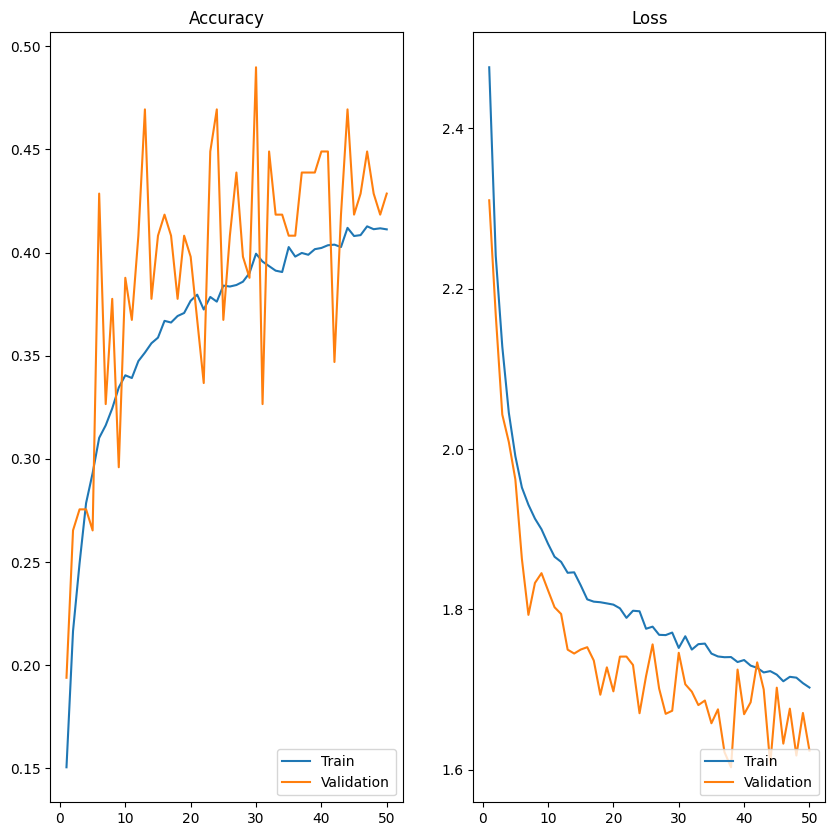

In [37]:
plot_loss_acc(epoch_num,train_loss,val_loss,train_acc,val_acc)

#### Version 3

In [28]:
LEARNING_RATE = 0.0005

In [22]:
# version 3
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.pool=nn.MaxPool2d((2,2))
        self.conv1=nn.Conv2d(3,12,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv2=nn.Conv2d(12,24,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv3=nn.Conv2d(24,24,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv4=nn.Conv2d(24,48,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.norm1=nn.BatchNorm2d(12)
        self.norm2=nn.BatchNorm2d(24)
        self.norm3=nn.BatchNorm2d(48)
        self.drop1=nn.Dropout2d(0.5)
        
        self.lin1=nn.Linear(48*16*16,1024)
        self.lin2=nn.Linear(1024,512)
        self.lin3=nn.Linear(512,512)
        self.lin4=nn.Linear(512,num_classes)
        self.norm4=nn.BatchNorm1d(1024)
        self.norm5=nn.BatchNorm1d(512)
        self.drop2=nn.Dropout(0.5)

    def forward(self, x):
        x=F.relu(self.pool(self.conv1(x))) 
        x=self.norm1(x)
        x=F.relu(self.pool(self.conv2(x)))
        x=self.norm2(x)
        x=F.relu(self.pool(self.conv3(x)))
        x=self.norm2(x)
        x=F.relu(self.pool(self.conv4(x)))
        x=self.norm3(x)
        x=F.dropout(self.drop1(x),training=self.training)
        
        # print(x.shape)
        x=x.view(-1,48*16*16)
        
        x=self.lin1(x)
        x=self.drop2(x)
        x=F.relu(self.norm4(x))
        x=self.lin2(x)
        x=self.drop2(x)
        x=F.relu(self.norm5(x))
        x=self.lin3(x)
        x=self.drop2(x)
        x=F.relu(self.norm5(x))
        x=self.drop2(x)
        x=self.lin4(x)
        
        return torch.log_softmax(x, dim=1)

In [23]:
# version 3
model=CNN(num_classes=NUM_CLASSES)
save_name="flower_classification_model__pytorch_v3"
epoch_num,train_loss,val_loss,train_acc,val_acc=train_pytorch_model(model,save_name=save_name)

Epoch: 1; Training Avg Loss: 2.31609, Accuracy:18.80%
	Validation Avg Loss: 1.94648, Accuracy:37.76%
Epoch: 2; Training Avg Loss: 1.93609, Accuracy:30.43%
	Validation Avg Loss: 1.77369, Accuracy:29.59%
Epoch: 3; Training Avg Loss: 1.79735, Accuracy:35.99%
	Validation Avg Loss: 1.75496, Accuracy:33.67%
Epoch: 4; Training Avg Loss: 1.73232, Accuracy:38.43%
	Validation Avg Loss: 1.65106, Accuracy:38.78%
Epoch: 5; Training Avg Loss: 1.66103, Accuracy:40.80%
	Validation Avg Loss: 1.55284, Accuracy:42.86%
Epoch: 6; Training Avg Loss: 1.61342, Accuracy:42.97%
	Validation Avg Loss: 1.57379, Accuracy:36.73%
Epoch: 7; Training Avg Loss: 1.58031, Accuracy:44.28%
	Validation Avg Loss: 1.77080, Accuracy:37.76%
Epoch: 8; Training Avg Loss: 1.55999, Accuracy:44.86%
	Validation Avg Loss: 1.83092, Accuracy:35.71%
Epoch: 9; Training Avg Loss: 1.53878, Accuracy:45.81%
	Validation Avg Loss: 1.68419, Accuracy:37.76%
Epoch: 10; Training Avg Loss: 1.50791, Accuracy:46.83%
	Validation Avg Loss: 1.56273, Accur

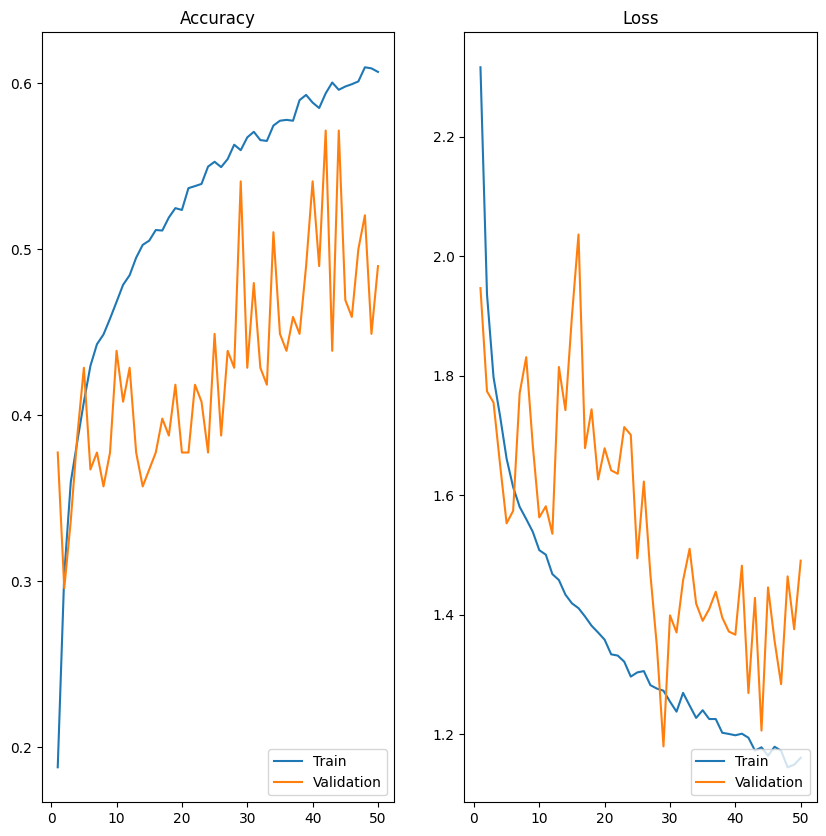

In [26]:
plot_loss_acc(epoch_num,train_loss,val_loss,train_acc,val_acc)

#### Version 4

In [389]:
# version 4
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.pool=nn.MaxPool2d((2,2))
        self.conv1=nn.Conv2d(3,12,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv2=nn.Conv2d(12,24,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.drop=nn.Dropout2d(0.2)
        
        self.lin1 = nn.Linear(64*64*24,num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.dropout(self.drop(x),training=self.training)
        x = x.view(-1,64*64*24)
        x = self.lin1(x)
        
        return torch.log_softmax(x, dim=1)

In [373]:
# version 4
model=CNN(num_classes=NUM_CLASSES)
save_name="flower_classification_model__pytorch_v4"
epoch_num,train_loss,val_loss,train_acc,val_acc=train_pytorch_model(model,save_name=save_name)

Epoch: 1; Training Avg Loss: 2.12558, Accuracy:26.91%
	Validation Avg Loss: 1.82373, Accuracy:33.67%
Epoch: 2; Training Avg Loss: 1.86895, Accuracy:35.52%
	Validation Avg Loss: 1.66666, Accuracy:39.80%
Epoch: 3; Training Avg Loss: 1.80188, Accuracy:37.69%
	Validation Avg Loss: 1.61445, Accuracy:41.84%
Epoch: 4; Training Avg Loss: 1.75315, Accuracy:39.81%
	Validation Avg Loss: 1.67573, Accuracy:46.94%
Epoch: 5; Training Avg Loss: 1.72469, Accuracy:41.04%
	Validation Avg Loss: 1.51745, Accuracy:37.76%
Epoch: 6; Training Avg Loss: 1.70056, Accuracy:42.02%
	Validation Avg Loss: 1.72441, Accuracy:42.86%
Epoch: 7; Training Avg Loss: 1.67620, Accuracy:42.60%
	Validation Avg Loss: 2.14638, Accuracy:42.86%
Epoch: 8; Training Avg Loss: 1.65938, Accuracy:43.29%
	Validation Avg Loss: 1.51630, Accuracy:44.90%
Epoch: 9; Training Avg Loss: 1.63420, Accuracy:44.15%
	Validation Avg Loss: 1.71961, Accuracy:53.06%
Epoch: 10; Training Avg Loss: 1.62392, Accuracy:45.07%
	Validation Avg Loss: 1.48650, Accur

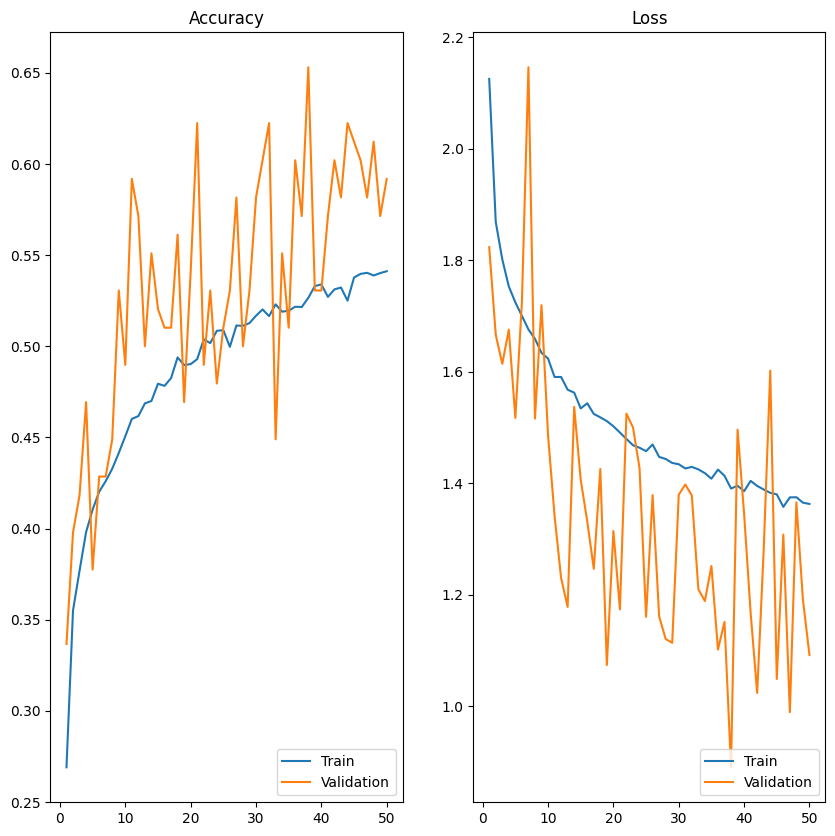

In [374]:
# version 4 --> "flower_classification_model__pytorch_v4"
plot_loss_acc(epoch_num,train_loss,val_loss,train_acc,val_acc)
# unstable jumps may be due to high batch variance

#### Version 5

In [50]:
# version 5
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.conv1=nn.Conv2d(3,16,kernel_size=(5,5),stride=(2,2),padding=(2,2))
        self.conv2=nn.Conv2d(16,3,kernel_size=(50,50),stride=(1,1))
        self.relu=nn.ReLU(inplace = True)
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)
        self.pool2=nn.MaxPool2d(kernel_size=1,stride=1,padding=0,ceil_mode=False)
        
        self.lin1=nn.Sequential(nn.Linear(3*15*15,num_classes))
        
    def forward(self,x):
        x=self.pool1(self.relu(self.conv1(x)))
        x=self.pool2(self.conv2(x))
        # print(x.shape)
        x=x.view(-1,3*15*15) # basically a flatten
        x=self.lin1(x)
        
        return torch.log_softmax(x, dim=1)

In [51]:
# version 5
model=CNN(num_classes=NUM_CLASSES)
save_name="flower_classification_model__pytorch_v5"
epoch_num,train_loss,val_loss,train_acc,val_acc=train_pytorch_model(model,save_name=save_name)
# accuracy and loss not improving

Epoch: 1; Training Avg Loss: 2.44736, Accuracy:15.13%
	Validation Avg Loss: 2.14473, Accuracy:20.41%
Epoch: 2; Training Avg Loss: 2.07460, Accuracy:25.34%
	Validation Avg Loss: 1.98650, Accuracy:26.53%
Epoch: 3; Training Avg Loss: 2.00242, Accuracy:26.69%
	Validation Avg Loss: 1.95986, Accuracy:27.55%
Epoch: 4; Training Avg Loss: 1.96813, Accuracy:27.08%
	Validation Avg Loss: 1.87027, Accuracy:32.65%
Epoch: 5; Training Avg Loss: 1.95700, Accuracy:27.55%
	Validation Avg Loss: 1.90360, Accuracy:28.57%
Epoch: 6; Training Avg Loss: 1.92628, Accuracy:29.07%
	Validation Avg Loss: 1.75983, Accuracy:36.73%
Epoch: 7; Training Avg Loss: 1.91267, Accuracy:29.57%
	Validation Avg Loss: 1.84630, Accuracy:26.53%
Epoch: 8; Training Avg Loss: 1.89610, Accuracy:29.70%
	Validation Avg Loss: 1.82549, Accuracy:27.55%
Epoch: 9; Training Avg Loss: 1.88216, Accuracy:30.78%
	Validation Avg Loss: 1.82506, Accuracy:30.61%
Epoch: 10; Training Avg Loss: 1.86922, Accuracy:31.10%
	Validation Avg Loss: 1.77062, Accur

KeyboardInterrupt: 

#### Version 6

In [29]:
# version 6
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.pool=nn.MaxPool2d((2,2))
        self.conv1=nn.Conv2d(3,12,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv2=nn.Conv2d(12,24,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.drop=nn.Dropout2d(0.2)
        
        self.lin1 = nn.Linear(64*64*24,512)
        self.lin2 = nn.Linear(512,num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.dropout(self.drop(x),training=self.training)
        x = x.view(-1,64*64*24)
        x = self.lin1(x)
        
        return torch.log_softmax(x, dim=1)

In [30]:
# version 6
model=CNN(num_classes=NUM_CLASSES)
save_name="flower_classification_model__pytorch_v6"
epoch_num,train_loss,val_loss,train_acc,val_acc=train_pytorch_model(model,save_name=save_name)

Epoch: 1; Training Avg Loss: 2.24509, Accuracy:24.23%
	Validation Avg Loss: 1.75564, Accuracy:38.78%
Epoch: 2; Training Avg Loss: 1.86598, Accuracy:35.34%
	Validation Avg Loss: 1.79622, Accuracy:41.84%
Epoch: 3; Training Avg Loss: 1.81130, Accuracy:37.24%
	Validation Avg Loss: 1.66671, Accuracy:41.84%
Epoch: 4; Training Avg Loss: 1.76032, Accuracy:39.98%
	Validation Avg Loss: 1.64815, Accuracy:41.84%
Epoch: 5; Training Avg Loss: 1.73846, Accuracy:40.08%
	Validation Avg Loss: 1.65995, Accuracy:39.80%
Epoch: 6; Training Avg Loss: 1.73003, Accuracy:40.35%
	Validation Avg Loss: 1.56114, Accuracy:50.00%
Epoch: 7; Training Avg Loss: 1.71236, Accuracy:41.33%
	Validation Avg Loss: 1.57508, Accuracy:46.94%
Epoch: 8; Training Avg Loss: 1.70055, Accuracy:42.11%
	Validation Avg Loss: 1.61668, Accuracy:45.92%
Epoch: 9; Training Avg Loss: 1.67045, Accuracy:43.16%
	Validation Avg Loss: 1.51939, Accuracy:47.96%
Epoch: 10; Training Avg Loss: 1.64649, Accuracy:44.27%
	Validation Avg Loss: 1.64952, Accur

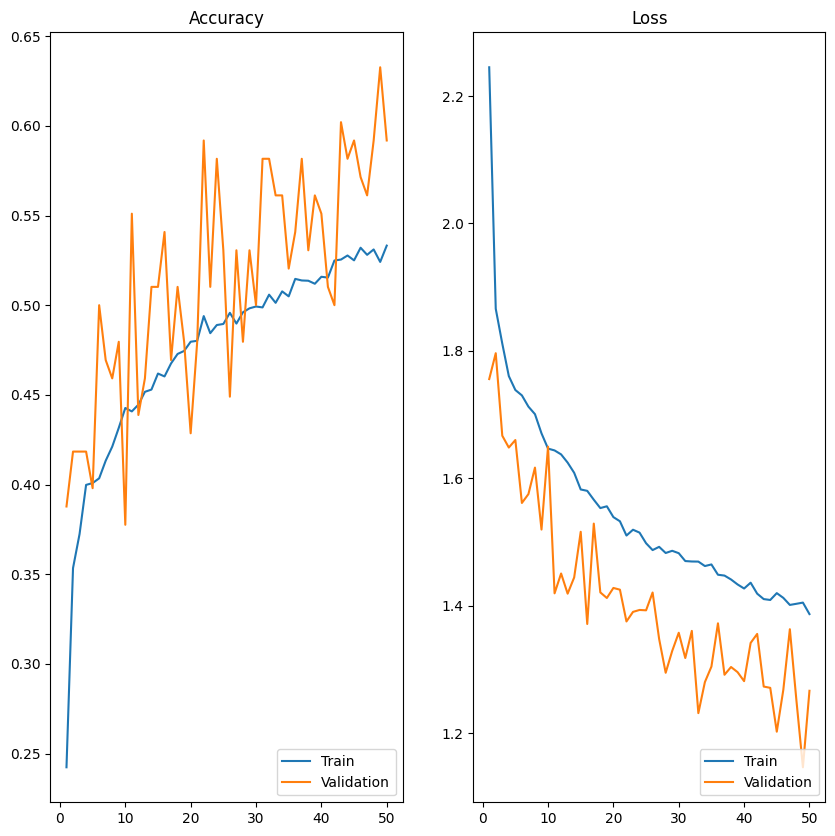

In [31]:
# version 6 --> "flower_classification_model__pytorch_v6"
plot_loss_acc(epoch_num,train_loss,val_loss,train_acc,val_acc)
# loss decrease is much more stable and accuracy about the same compared to version 4